# 1. Импортируем необходимые библиотеки

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import re
from collections import Counter

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# 2. Считаем и посмотрим на данные

In [2]:
data_all = pd.read_csv('regulations.csv', index_col='id')
data_all.head()

,act_title,publication_date,developer,okved_list,views_num,comments_num,likes_num,dislikes_num,regulatory_impact,added_by,responsible,is_regionally_signigicant,act_changes_controlling_activities,mineco_solution,problem_addressed,act_objectives,persons_affected_by_act,relations_regulated_by_act,act_significance
id,,,,,,,,,,,,,,,,,,,
5038,Об утверждении тарифов на услуги по транспорти...,2013-09-11,ФСТ России,NaN,376.0,0.0,0.0,0.0,Низкая,Митина Ольга Викторовна,Митина Ольга Викторовна,False,False,Не определено,NaN,NaN,NaN,NaN,NaN
5039,О внесении изменений в отдельные законодательн...,2013-06-11,Минтруд России,Здравоохранение; Предоставление социальных услуг,504.0,0.0,0.0,0.0,Низкая,Рахов Виталий Сергеевич,Павлова Зоя Ивановна,False,False,Не определено,NaN,NaN,NaN,NaN,NaN
5040,Об утверждении Положения об уведомлении лиц об...,2013-04-29,Росфинмониторинг,Финансовая деятельность,428.0,0.0,0.0,0.0,Низкая,Тимофеева Алёна Игоревна,Лях Валерий Владимирович,False,False,Не определено,NaN,NaN,NaN,NaN,NaN
5041,О внесении изменений в Положение о Министерств...,2013-10-21,Минобрнауки России,Образование,376.0,0.0,0.0,0.0,Низкая,Вотоновская Ирина Вячеславовна,Михайлова Ирина Вячеславовна,False,False,Не определено,NaN,NaN,NaN,NaN,NaN
5042,О внесении изменений в Правила подготовки и пр...,2014-02-24,Минприроды России,NaN,499.0,0.0,0.0,0.0,Низкая,Соболева Светлана Юрьевна,Соболева Светлана Юрьевна,False,False,Не определено,предоставление водного объекта в пользование п...,Пунктом 12 части 2 статьи 11 Водного кодекса Р...,неопределенный круг лиц,необходимость корреляции Правил подготовки и п...,Проект постановления Правительства Российской ...


In [3]:
data_all.shape

(85006, 19)

## Выделим тренировочные данные

In [4]:
# Возьмем индексы и ответы для train из train_answers
train_ind_ans= pd.read_csv('train_answer.csv')
train_indecies = train_ind_ans['id']
train_answers = train_ind_ans['passed']

# Добавим колонку с ответами
train_data = data_all.loc[train_indecies]
train_data['passed'] = train_answers.values

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81006 entries, 5038 to 120262
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   act_title                           81005 non-null  object 
 1   publication_date                    80417 non-null  object 
 2   developer                           80221 non-null  object 
 3   okved_list                          69450 non-null  object 
 4   views_num                           80417 non-null  float64
 5   comments_num                        80417 non-null  float64
 6   likes_num                           80417 non-null  float64
 7   dislikes_num                        80417 non-null  float64
 8   regulatory_impact                   80417 non-null  object 
 9   added_by                            80417 non-null  object 
 10  responsible                         77684 non-null  object 
 11  is_regionally_signigicant           8

В данных очень много пропусков, будем постепенно от них избавляться

In [6]:
# Проверим соотношение классов

print(f'Доля первого класса: {round(sum(train_data.passed)/len(train_data.passed),2)}')
train_data.passed.value_counts()

Доля первого класса: 0.14


0    69701
1    11305
Name: passed, dtype: int64

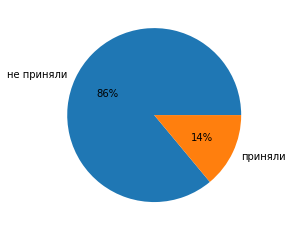

In [7]:
labels = ['не приняли', 'приняли']
plt.pie(train_data.passed.value_counts(), labels=labels, autopct='%.0f%%')
plt.show()

Разница в соотношении классов есть, но она не выглядит экстремальной

## Выделим тестовые данные

In [8]:
# Возьмем индексы для test из sample_submission
test_indecies = pd.read_csv('sample_submission.csv')['id']
test_data = data_all.loc[test_indecies]

In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 46050 to 77961
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   act_title                           4000 non-null   object 
 1   publication_date                    4000 non-null   object 
 2   developer                           4000 non-null   object 
 3   okved_list                          3647 non-null   object 
 4   views_num                           4000 non-null   float64
 5   comments_num                        4000 non-null   float64
 6   likes_num                           4000 non-null   float64
 7   dislikes_num                        4000 non-null   float64
 8   regulatory_impact                   4000 non-null   object 
 9   added_by                            4000 non-null   object 
 10  responsible                         4000 non-null   object 
 11  is_regionally_signigicant           40

In [10]:
# Проверим, все ли данные разделили на train и test
data_all.shape[0] == train_data.shape[0] + test_data.shape[0]

True

# 3. Подготовим и проанализируем данные

In [11]:
# Подготовим списки для разделения всех колонок на 3 вида - бинарные, числовые и категориальные

binary_features = []
numeric_features = []
categorical_features = []

## 3.1 Колонка act_title

act_title - название НПА

In [12]:
# Посмотрим на самые популярные значения

train_data.act_title.value_counts()[:10]

О внесении изменений в некоторые акты Правительства Российской Федерации                                                                                                                                                                                                                636
Проект удален                                                                                                                                                                                                                                                                           589
О внесении изменений в отдельные законодательные акты Российской Федерации                                                                                                                                                                                                              133
О внесении изменений в Кодекс Российской Федерации об административных правонарушениях                                                              

In [13]:
# Посмотрим, что из себя представляют данные со значением 'Проект удален'

train_data[train_data.act_title == 'Проект удален'].head()

,act_title,publication_date,developer,okved_list,views_num,comments_num,likes_num,dislikes_num,regulatory_impact,added_by,responsible,is_regionally_signigicant,act_changes_controlling_activities,mineco_solution,problem_addressed,act_objectives,persons_affected_by_act,relations_regulated_by_act,act_significance,passed
id,,,,,,,,,,,,,,,,,,,,
23312,Проект удален,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
23374,Проект удален,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
24276,Проект удален,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
24351,Проект удален,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
24396,Проект удален,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [14]:
test_data[test_data.act_title == 'Проект удален']

,act_title,publication_date,developer,okved_list,views_num,comments_num,likes_num,dislikes_num,regulatory_impact,added_by,responsible,is_regionally_signigicant,act_changes_controlling_activities,mineco_solution,problem_addressed,act_objectives,persons_affected_by_act,relations_regulated_by_act,act_significance
id,,,,,,,,,,,,,,,,,,,


In [15]:
# В тренировочных данных большое количество удаленных проектов, в тестовых их нет. Удалим такие проекты


train_data = train_data[train_data.act_title != 'Проект удален']
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80417 entries, 5038 to 120262
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   act_title                           80416 non-null  object 
 1   publication_date                    80417 non-null  object 
 2   developer                           80221 non-null  object 
 3   okved_list                          69450 non-null  object 
 4   views_num                           80417 non-null  float64
 5   comments_num                        80417 non-null  float64
 6   likes_num                           80417 non-null  float64
 7   dislikes_num                        80417 non-null  float64
 8   regulatory_impact                   80417 non-null  object 
 9   added_by                            80417 non-null  object 
 10  responsible                         77684 non-null  object 
 11  is_regionally_signigicant           8

### Выделим начала названий

In [17]:
# Заполним пропуски

train_data.act_title.fillna('no title', inplace = True)

In [18]:
# Список 'о внесении изменений в '

start_list_change = ['федеральный', 'приказ', 'правила', 'отдельные', 'постановление']
start_list_change_eng = ['title_fed', 'title_order', 'title_rules', 'title_sep', 'title_decree']

In [19]:
for i in range(len(start_list_change)):
        start= f'о внесении изменений в {start_list_change[i]}'
        title = start_list_change_eng[i]
        
        train_data[title] = [1 if str(t).lower().startswith(start) else 0 for t in train_data.act_title]
        test_data[title] = [1 if str(t).lower().startswith(start) else 0 for t in test_data.act_title]
        
        print(f'{start} :\n{train_data[title].value_counts()}')
        binary_features.append(title)


о внесении изменений в федеральный :
0    79021
1     1396
Name: title_fed, dtype: int64
о внесении изменений в приказ :
0    76800
1     3617
Name: title_order, dtype: int64
о внесении изменений в правила :
0    78321
1     2096
Name: title_rules, dtype: int64
о внесении изменений в отдельные :
0    79588
1      829
Name: title_sep, dtype: int64
о внесении изменений в постановление :
0    77432
1     2985
Name: title_decree, dtype: int64


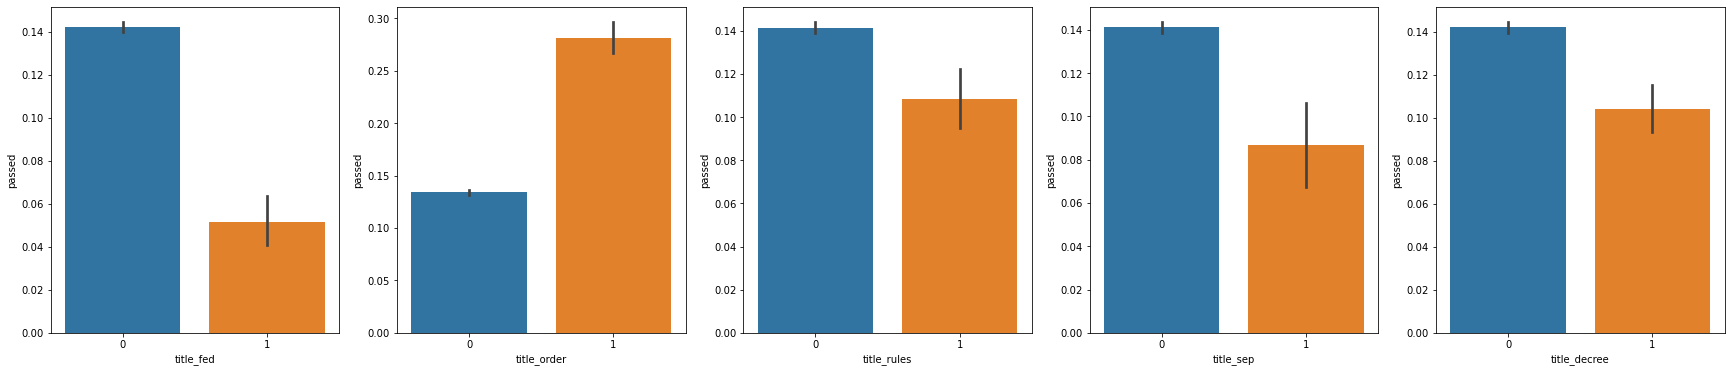

In [20]:
fig, saxis = plt.subplots(1, len(start_list_change),figsize=(len(start_list_change) * 6,6))
for ind, x in enumerate(start_list_change_eng):
    sns.barplot(x, y="passed", data=train_data, ax = saxis[ind])

### Пробовала:

- закодировать как категориальный признак
- выделять наиболее часто встречающиеся слова
- учитывать различия проектов, которые начинаются с "об утверждении"

## 3.2 Колонка publication_date	

publication_date - Дата публикации проекта НПА на сайте

In [21]:
train_data.publication_date.value_counts()

2013-07-09    165
2017-05-04    132
2013-06-11    129
2013-07-08    129
2017-11-21    119
             ... 
2016-05-09      1
2021-05-10      1
2016-02-27      1
2017-10-22      1
2015-08-30      1
Name: publication_date, Length: 2558, dtype: int64

In [22]:
# Напишем функцию по выделению года и месяца

def dates(data):
    dates_list = [date.split('-') for date in data.publication_date]
    data['year'] = [int(date[0])  for date in dates_list]
    data['month'] = [int(date[1]) for date in dates_list]

In [23]:
dates(train_data)
dates(test_data)

train_data.year.value_counts()

2017    9860
2014    9602
2016    9431
2020    9428
2015    9321
2019    9282
2018    8502
2013    8241
2021    6730
2012      19
2007       1
Name: year, dtype: int64

In [24]:
test_data.year.value_counts()

2020    585
2018    549
2019    529
2017    442
2021    442
2015    441
2016    424
2014    409
2013    177
2012      2
Name: year, dtype: int64

In [25]:
# В тестовых данных нет 2007 года, в тренировочных только 1, поэтому удалим эту строчку

train_data = train_data[train_data.year !=2007]

<AxesSubplot:xlabel='year', ylabel='passed'>

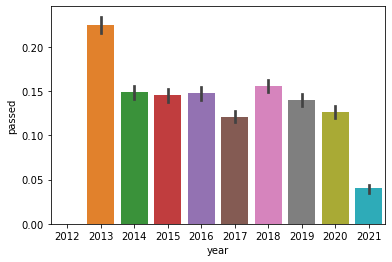

In [26]:
sns.barplot(train_data.year, train_data.passed)

<AxesSubplot:xlabel='month', ylabel='passed'>

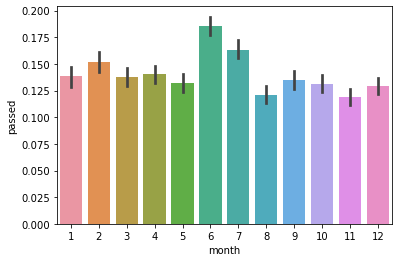

In [27]:
sns.barplot(train_data.month, train_data.passed)

По графикам видно, что год и месяц скорее категориальные признаки, чем числовые

In [28]:
categorical_features.append('year')
categorical_features.append('month')
categorical_features

['year', 'month']

### Пробовала:

- объединять признаки года и месяца

## 3.3 Колонка developer

developer - разработчик НПА

In [29]:
# Количество уникальных значений в колонке

len(train_data.developer.value_counts())

97

In [30]:
#Посмотрим на разработчиков

set([dev for dev in train_data.developer])

{nan,
 'ГУСП',
 'ГФС России',
 'Генеральная прокуратура Российской Федерации',
 'Госкорпорация "Росатом"',
 'Госкорпорация "Роскосмос"',
 'Единый государственный заказчик в сфере строительства',
 'Казначейство России',
 'Коллегия Военно-промышленной комиссии Российской Федерации',
 'МВД России',
 'МИД России',
 'МЧС России',
 'Минвостокразвития России',
 'Минздрав России',
 'Министерство Российской Федерации по делам Крыма',
 'Министерство науки и высшего образования Российской Федерации (Минобрнауки России)',
 'Министерство цифрового развития, связи и массовых коммуникаций России',
 'Минкавказ России',
 'Минкомсвязь России',
 'Минкультуры России',
 'Минобороны России',
 'Минобрнауки России',
 'Минприроды России',
 'Минпромторг России',
 'Минпросвещения России',
 'Минрегион России',
 'Минсельхоз России',
 'Минспорт России',
 'Минстрой России',
 'Минтранс России',
 'Минтруд России',
 'Минфин России',
 'Минэкономразвития России',
 'Минэнерго России',
 'Минюст России',
 'Пенсионный фонд Р

In [31]:
# Названия минобрнауки различаются, оставим одно

train_data['developer'][train_data.developer == \
                      'Министерство науки и высшего образования Российской Федерации (Минобрнауки России)'] = 'Минобрнауки России'
test_data['developer'][test_data.developer == \
                      'Министерство науки и высшего образования Российской Федерации (Минобрнауки России)'] = 'Минобрнауки России'

In [32]:
# Заполним пропуски
train_data.developer.fillna('другой', inplace=True)
test_data.developer.fillna('другой', inplace=True)

In [33]:
categorical_features.append('developer')

### Пробовала:

- ограничить количество категорий, оставить наиболее часто встречающиеся, но лучший результат показывает вариант, когда оставляем всех разработчиков

## 3.4 Колонка okeved_list

okved_list - Список ОКВЭДов. Отражает виды экономической деятельности, регулируемый проектом.

In [34]:
# Посмотрим на самые часто встречающиеся значения
train_data.okved_list.value_counts()[:20]

Государственное управление                                                              18065
Финансовая деятельность                                                                  8042
Образование                                                                              7285
Транспорт                                                                                5679
Здравоохранение                                                                          2903
Прочие производства                                                                      2683
Сельское хозяйство                                                                       2066
Строительство                                                                            1652
Обеспечение военной безопасности                                                         1457
Производство и распределение электроэнергии, газа и воды                                 1431
Связь                                                       

In [35]:
len(train_data.okved_list.value_counts())

795

In [36]:
# Заполним пропущенные значения

train_data.okved_list.fillna('другие', inplace=True)
test_data.okved_list.fillna('другие', inplace=True)

In [37]:
# Функция выделения первого оквед кода

def okved(data):
    return  [okved.split(';')[0] for okved in data.okved_list]

train_data['okved'] = okved(train_data)
test_data['okved']  = okved(test_data)

In [38]:
train_data.okved.value_counts()

Государственное управление                                             19612
другие                                                                 10967
Финансовая деятельность                                                 8416
Образование                                                             7347
Транспорт                                                               5797
Здравоохранение                                                         4162
Сельское хозяйство                                                      2990
Прочие производства                                                     2834
Строительство                                                           2260
Обеспечение военной безопасности                                        1606
Производство и распределение электроэнергии, газа и воды                1484
Предоставление социальных услуг                                         1365
Связь                                                                   1338

In [39]:
len(train_data.okved.value_counts())

57

In [40]:
categorical_features.append('okved')

### Пробовала:

- ограничить количество категорий, оставить наиболее часто встречающиеся, но лучший результат показывает вариант, когда оставляем все коды
- включать вторые и т.д. оквед коды
- добавить признак - количество кодов
- добавить признак - отсутствия/наличие одного/больше одного кодов


## 3.5 Колонки views_num, comments_num, likes_num, dislikes_num

views_num - Количество просмотров страницы, на которой размещён проект НПА

comments_num - Количество комментариев к проекту НПА на сайте

likes_num - Количество «лайков» проекта НПА на сайте

dislikes_num - Количество «дизлайков» проекта НПА на сайте

In [41]:
num_list = ['views_num', 'comments_num', 'likes_num', 'dislikes_num']

for col in num_list:
    print(f'{col}:\ntrain data\n{train_data[col].describe()}\n')
    print(f'test data\n{test_data[col].describe()}\n')
    print('---------')

views_num:
train data
count     80416.000000
mean        872.261092
std        4372.486546
min           7.000000
25%         252.000000
50%         412.000000
75%         884.000000
max      811307.000000
Name: views_num, dtype: float64

test data
count      4000.000000
mean       1414.822500
std        4478.985478
min         114.000000
25%         435.750000
50%         822.500000
75%        1252.000000
max      188390.000000
Name: views_num, dtype: float64

---------
comments_num:
train data
count    80416.000000
mean         0.936903
std         45.364366
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       7961.000000
Name: comments_num, dtype: float64

test data
count    4000.00000
mean        5.04325
std        36.04272
min         0.00000
25%         0.00000
50%         0.00000
75%         2.25000
max      1899.00000
Name: comments_num, dtype: float64

---------
likes_num:
train data
count     80416.000000
mean          5.546272
std

Пропусков в данных нет.

Мы видим, и это вполне ожидаемо, что люди в основном не оставляют комментариев, не ставят лайки и дизлайки

In [42]:
train_data[num_list].corr()

,views_num,comments_num,likes_num,dislikes_num
views_num,1.000000,0.091781,0.131322,0.245321
comments_num,0.091781,1.000000,0.074937,0.117673
likes_num,0.131322,0.074937,1.000000,0.983167
dislikes_num,0.245321,0.117673,0.983167,1.000000


<AxesSubplot:>

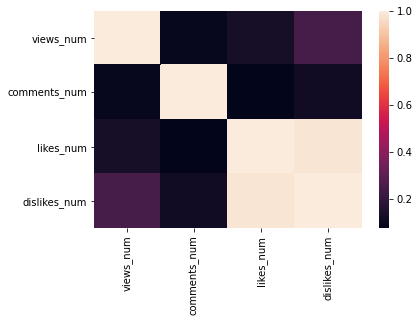

In [43]:
sns.heatmap(train_data[num_list].corr())

In [44]:
train_data[(train_data.likes_num==0) & (train_data.dislikes_num==0)].shape[0]

64503

Данные по лайкам и дизлайкам очень сильно коррелируют, но если убирать один из этих показателей, качество заметно ухудшается.

In [45]:
# Просто добавим колонки в числовые значения как есть

numeric_features.extend(num_list)

### Пробовала:

- оставлять только лайки/дизлайки
- заменить колонки лайков и дизлайков на показатель разницы между ними


## 3.6 Колонки regulatory_impact

regulatory_impact - Степень регулирующего воздействия проекта НПА

In [46]:
train_data.regulatory_impact.value_counts()

Не определена    57403
Низкая           16944
Средняя           4532
Высокая           1537
Name: regulatory_impact, dtype: int64

<AxesSubplot:xlabel='regulatory_impact', ylabel='passed'>

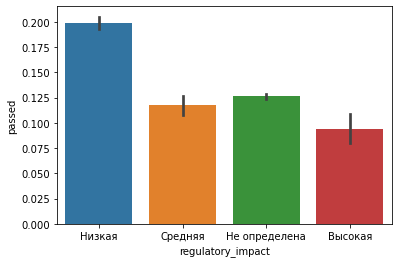

In [47]:
sns.barplot(train_data.regulatory_impact, train_data.passed)

In [48]:
# Пропусков в данных нет, добавим признак к категориальным как есть

categorical_features.append('regulatory_impact')

### Пробовала:

- преобразовать в ранговый признак


## 3.7 Колонки added_by, responsible

added_by - ФИО создателя проекта нормативного правового акта

responsible - ФИО ответственного за проект нормативного правового акта

In [49]:
# Заполним пропуски в колонке responsible
train_data.responsible.fillna('другое', inplace=True)
test_data.responsible.fillna('другое', inplace = True)

In [50]:
train_data.added_by.value_counts()

Рыбина Ольга Алексеевна              4611
Радецкий Максим                      2852
Гуляков Андрей Сергеевич             2633
Куликова Наталия Борисовна           2133
Абросимов Валерий Валерьевич         1916
                                     ... 
Петров Дмитрий Валерьевич               1
Тен Елена Владимировна                  1
Чернышев Федор Вячеславович             1
Бараблина Элеонора Константиновна       1
Клинова Наталия Вячеславовна            1
Name: added_by, Length: 2797, dtype: int64

In [51]:
# Функция для составления списков имен, встречающихся минимум 3 раза

def name_list_collect(column, col_name):
    name_list_train = [''.join(name.lower().strip().split(' ')[0:3]) for name in train_data[column]]
    name_list_test = [''.join(name.lower().strip().split(' ')[0:3]) for name in test_data[column]]
    
    counter = Counter(name_list_train)
    name_list = [name for name, count in counter.items() if count > 2 ]
    
    train_data[col_name] = [name if name in name_list else 'другое' for name in name_list_train]
    test_data[col_name] = [name if name in name_list else 'другое' for name in name_list_test]

name_list_collect('added_by', 'name')
name_list_collect('responsible', 'name_resp')


Кажется, что это вообще самые главные признаки

In [52]:
categorical_features.extend(['name', 'name_resp'])

### Пробовала:

- ограничить количество категорий, оставить наиболее часто встречающиеся
- добавить взаимосвязь между этими колонкками

## 3.8 Колонки  is_regionally_signigicant , act_changes_controlling_activities

is_regionally_signigicant - Затрагивает ли проект НПА вопросы экономического развития регионов

act_changes_controlling_activities - Предполагает ли проект НПА требования, которые проверяются в рамках контрольно-надзорной деятельности, или изменения в порядке контрольно-надзорной деятельности

In [53]:
# Эти признаки относятся к бинарным

bin_feat = ['is_regionally_signigicant', 'act_changes_controlling_activities']


for feat in bin_feat:
    train_data[feat] = [1 if x else 0 for x in train_data[feat]]
    test_data[feat] = [1 if x else 0 for x in test_data[feat]]

    
train_data[bin_feat].corr()

,is_regionally_signigicant,act_changes_controlling_activities
is_regionally_signigicant,1.000000,0.099418
act_changes_controlling_activities,0.099418,1.000000


In [54]:
#Корреляция между ними небольшая, добавим оба

binary_features.extend(bin_feat)

## 3.9 Колонка mineco_solution

mineco_solution - Заключение Минэкономразвития об оценке регулирующего воздействия

In [55]:
train_data.mineco_solution.value_counts()

Не определено    74852
Положительное     3967
Отрицательное     1597
Name: mineco_solution, dtype: int64

<AxesSubplot:xlabel='mineco_solution', ylabel='passed'>

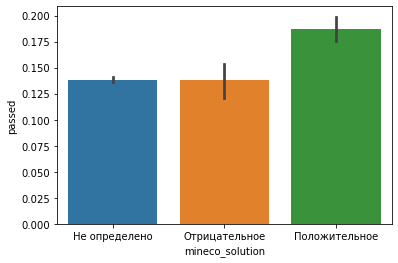

In [56]:
sns.barplot(train_data.mineco_solution, train_data.passed)

In [57]:
categorical_features.append('mineco_solution')

## 3.10 Колонки problem_addressed,  act_objectives, persons_affected_by_act , relations_regulated_by_act,  act_significance 

problem_addressed - Краткое описание проблемы, на решение которой направлен предлагаемый способ регулирования

act_objectives - Краткое изложение целей регулирования

persons_affected_by_act - Круг лиц, на которых будет распространено действие нормативного правового акта

relations_regulated_by_act - Общая характеристика соответствующих общественных отношений

act_significance - Обоснование необходимости подготовки проекта нормативного правового акта

In [58]:
columns = ['problem_addressed', 'act_objectives', 'persons_affected_by_act', 
        'relations_regulated_by_act', 'act_significance']

In [59]:
for col in columns:
    train_data[col].fillna(0, inplace=True)
    test_data[col].fillna(0, inplace=True)
    
    train_data[col] = [1 if x else 0 for x in train_data[col]]
    test_data[col] = [1 if x else 0 for x in test_data[col]]
    
    print(f'{col} :\n{train_data[col].value_counts()}')

problem_addressed :
0    63958
1    16458
Name: problem_addressed, dtype: int64
act_objectives :
0    71777
1     8639
Name: act_objectives, dtype: int64
persons_affected_by_act :
0    63958
1    16458
Name: persons_affected_by_act, dtype: int64
relations_regulated_by_act :
0    63956
1    16460
Name: relations_regulated_by_act, dtype: int64
act_significance :
0    63959
1    16457
Name: act_significance, dtype: int64


In [60]:
train_data[columns].corr()

,problem_addressed,act_objectives,persons_affected_by_act,relations_regulated_by_act,act_significance
problem_addressed,1.000000,0.683809,0.999771,0.999924,0.999885
act_objectives,0.683809,1.000000,0.683908,0.683757,0.683835
persons_affected_by_act,0.999771,0.683908,1.000000,0.999847,0.999733
relations_regulated_by_act,0.999924,0.683757,0.999847,1.000000,0.999885
act_significance,0.999885,0.683835,0.999733,0.999885,1.000000


<AxesSubplot:>

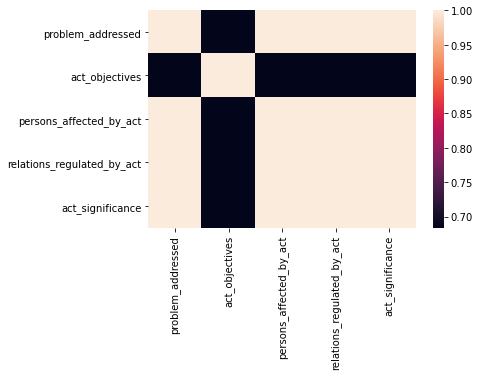

In [61]:
sns.heatmap(train_data[columns].corr())

Все эти признаки имеют огромное количество пропусков. 

К тому же, заполнение колонок очень скоррелировано, поэтому оставим только 1 из них. Другие сколько-нибудь полезные данные мне из них выделить не удалось

<AxesSubplot:xlabel='problem_addressed', ylabel='passed'>

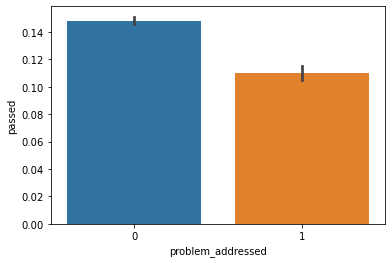

In [62]:
sns.barplot(train_data.problem_addressed, train_data.passed)

In [63]:
binary_features.append('problem_addressed')

### Пробовала:
- оставить другие признаки, этот показал максимальный результат
- выделить наиболее важные слова - 'указ президента', 'распоряжение правительства' и т.д.

### Посмотрим, какие списки признаков у нас получились

In [64]:
categorical_features

['year',
 'month',
 'developer',
 'okved',
 'regulatory_impact',
 'name',
 'name_resp',
 'mineco_solution']

In [65]:
numeric_features

['views_num', 'comments_num', 'likes_num', 'dislikes_num']

In [66]:
binary_features

['title_fed',
 'title_order',
 'title_rules',
 'title_sep',
 'title_decree',
 'is_regionally_signigicant',
 'act_changes_controlling_activities',
 'problem_addressed']

# 4. Модели

### Я пробовала  такие классификаторы как:
 - RandomForestClassifier,  
 - XGBClassifier, 
 - LGBMClassifier
 ### но у меня лучшее качество показал CatBoostClassifier, причем с параметрами по умолчанию

In [67]:
# Нормируем числовые данные с помощью StandardScaler

scaler = StandardScaler()
train_data[numeric_features] = scaler.fit_transform(train_data[numeric_features])
test_data[numeric_features] = scaler.transform(test_data[numeric_features])

In [68]:
# Данные для CatBoostClassifier

y_train_all = train_data.passed

X_train_all_cat = pd.concat([train_data[binary_features], train_data[numeric_features], 
                             train_data[categorical_features]], axis=1)

X_train_cat, X_valid_cat, y_train_cat, y_valid_cat= train_test_split(X_train_all_cat, y_train_all, 
                                                    train_size=0.8,
                                                    random_state=42)

X_test_cat = pd.concat([test_data[binary_features], test_data[numeric_features], 
                        test_data[categorical_features]], axis=1)

In [69]:
X_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64332 entries, 99220 to 23886
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   title_fed                           64332 non-null  int64  
 1   title_order                         64332 non-null  int64  
 2   title_rules                         64332 non-null  int64  
 3   title_sep                           64332 non-null  int64  
 4   title_decree                        64332 non-null  int64  
 5   is_regionally_signigicant           64332 non-null  int64  
 6   act_changes_controlling_activities  64332 non-null  int64  
 7   problem_addressed                   64332 non-null  int64  
 8   views_num                           64332 non-null  float64
 9   comments_num                        64332 non-null  float64
 10  likes_num                           64332 non-null  float64
 11  dislikes_num                        6

In [70]:
X_test_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 46050 to 77961
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   title_fed                           4000 non-null   int64  
 1   title_order                         4000 non-null   int64  
 2   title_rules                         4000 non-null   int64  
 3   title_sep                           4000 non-null   int64  
 4   title_decree                        4000 non-null   int64  
 5   is_regionally_signigicant           4000 non-null   int64  
 6   act_changes_controlling_activities  4000 non-null   int64  
 7   problem_addressed                   4000 non-null   int64  
 8   views_num                           4000 non-null   float64
 9   comments_num                        4000 non-null   float64
 10  likes_num                           4000 non-null   float64
 11  dislikes_num                        40

Пропусков в данных нет, можно переходить к обучению

### Обучим модель на тренировочных данных, проверим на валидационных и построим график

In [71]:
classifier = CatBoostClassifier(cat_features=categorical_features, silent = True)
classifier.fit(X_train_cat, y_train_cat)

train_predictions = classifier.predict_proba(X_train_cat)[:, 1]
valid_predictions = classifier.predict_proba(X_valid_cat)[:, 1]

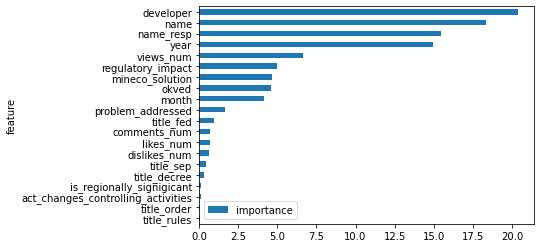

In [72]:
importance = pd.DataFrame({'feature':X_train_cat.columns, 'importance': classifier.feature_importances_})
importance.sort_values('importance', ascending=True).set_index('feature').plot(kind='barh')
plt.show()

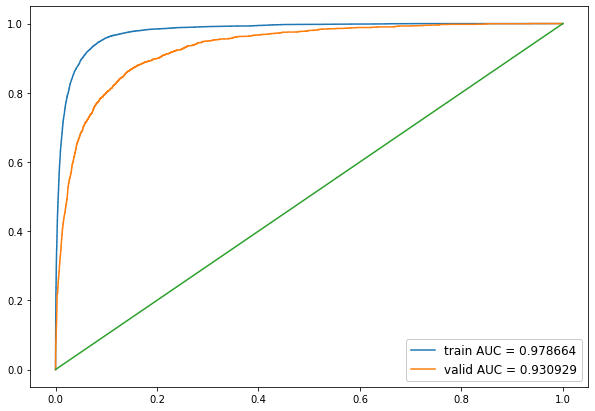

In [73]:
train_auc = roc_auc_score(y_train_cat, train_predictions)
valid_auc = roc_auc_score(y_valid_cat, valid_predictions)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train_cat, train_predictions)[:2], label = f'train AUC = {train_auc:.6f}')
plt.plot(*roc_curve(y_valid_cat, valid_predictions)[:2], label = f'valid AUC = {valid_auc:.6f}')

legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()

plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

Модель показывает хорошее качество.

## Обучим модель на всех данных

In [74]:
best_model = CatBoostClassifier(cat_features=categorical_features, silent = True)
best_model.fit(X_train_all_cat, y_train_all)

In [75]:
my_submission = pd.DataFrame(test_indecies)

In [76]:
preds = best_model.predict_proba(X_test_cat)[:, 1]

In [77]:
my_submission['passed'] = preds
my_submission

,id,passed
0,46050,0.001870
1,93905,0.020479
2,79028,0.061528
3,101050,0.298572
4,83386,0.035266
...,...,...
3995,5574,0.183993
3996,114992,0.574180
3997,113171,0.002870
3998,66872,0.038931


In [78]:
#my_submission.to_csv('./submission_Ayueva.csv', index=False)

Качество на Public Leaderboard - 0.91003

Качество на Private Leaderboard - 0.89055
